## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from sklearn.utils import shuffle

In [ ]:
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

def plot_calibration_curve(pred_probs, test_y, n_bins=10):
    # Ensure inputs are NumPy arrays
    pred_probs = np.array(pred_probs)
    test_y = np.array(test_y)

    # Create bins
    bin_edges = np.linspace(pred_probs.min(), pred_probs.max(), n_bins + 1)

    # Initialize lists for storing results
    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(bin_edges) - 1):
        # Identify predictions within the current bin
        mask = (pred_probs > bin_edges[i]) & (pred_probs <= bin_edges[i + 1])
        if np.sum(mask) > 0:  # Skip empty bins
            # Compute empirical probability and midpoint of the bin
            empirical_probs.append(np.mean(test_y[mask]))
            pred_probs_midpoints.append((bin_edges[i] + bin_edges[i + 1]) / 2)

    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o', label='XGBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
    plt.title("Calibration Curve for XGBoost", fontsize=16)
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Empirical Probability', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# mixUp data
def mixup_data(X, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    indices = np.random.permutation(X.shape[0])
    X_mix = lam * X + (1 - lam) * X[indices]
    y_mix = lam * y + (1 - lam) * y[indices]
    return X_mix, y_mix


def augment_with_mixup(X, y, alpha=0.4, repeat=3):
    X_augmented = []
    y_augmented = []
    for _ in range(repeat):
        X_mix, y_mix = mixup_data(X, y, alpha)
        X_augmented.append(X_mix)
        y_augmented.append(y_mix)
    
    X_augmented = np.vstack([X] + X_augmented)  # Original + augmented
    y_augmented = np.vstack([y] + y_augmented)  # Original + augmented
    
    return X_augmented, y_augmented


## Data Loading and Preprocessing

In [217]:
# load data
data = pd.read_csv('Knowledge_base_train.csv')
print(len(data))
features_order = data.columns[1:]
#save the order of the features
with open('features_order.pkl', 'wb') as f:
    pickle.dump(features_order, f)
data.head()

400


,class,num_clients,Sum of Instances in Clients,Max. Of Instances in Clients,Min. Of Instances in Clients,Stddev of Instances in Clients,Average Dataset Missing Values %,Min Dataset Missing Values %,Max Dataset Missing Values %,Stddev Dataset Missing Values %,...,Min No. Of Insignificant Lags in Target,Stddev No. Of Insignificant Lags in Target,Avg. No. Of Seasonality Components in Target,Max No. Of Seasonality Components in Target,Min No. Of Seasonality Components in Target,Stddev No. Of Seasonality Components in Target,Average Fractal Dimensionality Across Clients of Target,Maximum Period of Seasonality Components in Target Across Clients,Minimum Period of Seasonality Components in Target Across Clients,Entropy of Target Stationarity
0,XGBRegressor,10,13821,1383,1382,0.300000,4.992466,4.121475,5.571635,0.448970,...,0,0,2,2,2,0,0.009829,13,2,0.325083
1,XGBRegressor,5,4031,807,806,0.400000,4.762946,3.970223,6.203474,0.875041,...,0,0,0,0,0,0,0.033774,0,0,0.673012
2,HUBERREGRESSOR,5,17280,3456,3456,0.000000,5.104167,4.745370,5.295139,0.188945,...,2,0,0,0,0,0,0.017802,0,0,0.673012
3,LinearSVR,5,6911,1383,1382,0.400000,4.934113,4.052098,5.571635,0.524086,...,1,0,0,0,0,0,0.390252,0,0,0.000000
4,XGBRegressor,15,24181,1613,1612,0.249444,4.966717,3.535980,6.389578,0.693981,...,0,0,1,1,1,0,0.014879,4,4,0.392674


In [144]:
X = data.drop(['class'], axis=1)
y = pd.get_dummies(data['class'])
class_names_order = y.columns
#save the order of the classes
with open('class_names_order.pkl', 'wb') as f:
    pickle.dump(class_names_order, f)
print(X.shape, y.shape)

(400, 57) (400, 6)


**The dataset is too small**

In [284]:
# split data train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(320, 57) (80, 57) (320, 6) (80, 6)


In [285]:
# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Building

In [287]:
# train xgboost
model_base = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    n_jobs=-1,
    random_state=42
)
model_base.fit(X_train, y_train.values.argmax(axis=1))
print('XGBoost accuracy:', model_base.score(X_test, y_test.values.argmax(axis=1)))

XGBoost accuracy: 0.575


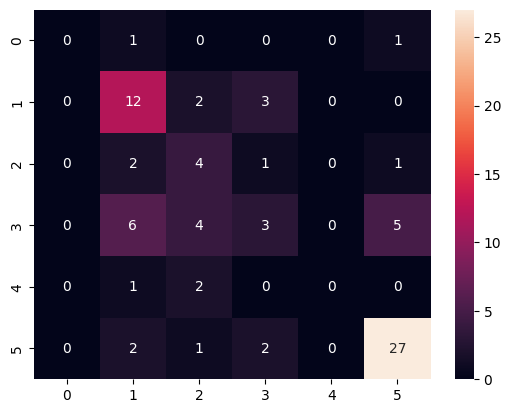

In [288]:
plot_confusion_matrix(model_base, X_test, y_test.values.argmax(axis=1))

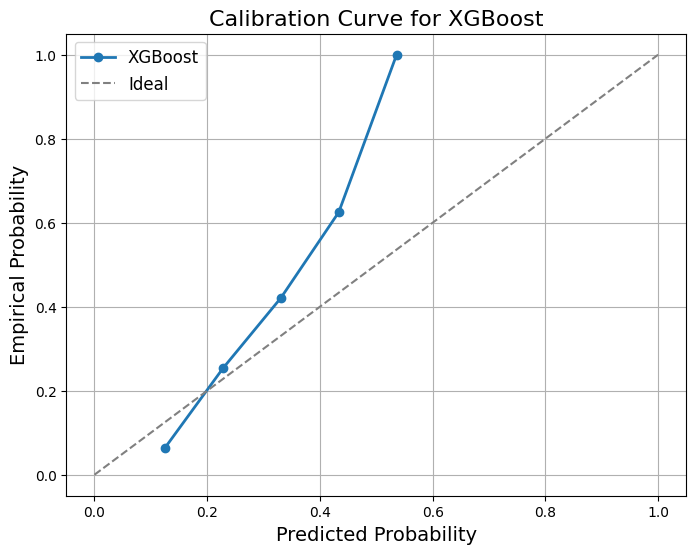

In [289]:
plot_calibration_curve(model_base.predict_proba(X_test), y_test.values, n_bins=5)

### Using mixUp 

In [299]:
x_train_mix, y_train_mix = augment_with_mixup(X_train, y_train.values, alpha=0.4, repeat=5)
# shuffle data
x_train_mix, y_train_mix = shuffle(x_train_mix, y_train_mix)
print(x_train_mix.shape, y_train_mix.shape)

(1920, 57) (1920, 6)


In [300]:
print(y_train_mix)

[[0.   0.   0.   0.   0.   1.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.51 0.   0.   0.   0.49]
 ...
 [0.   0.77 0.   0.   0.   0.23]
 [0.   0.23 0.   0.77 0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]]


In [296]:
# xgboost
model = xgb.XGBClassifier(objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.01,
    random_state=42)
model.fit(x_train_mix, np.argmax(y_train_mix, axis=1))

# evaluate model
print('XGBoost accuracy:', model.score(X_test, y_test.values.argmax(axis=1)))


XGBoost accuracy: 0.6


In [143]:
# save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

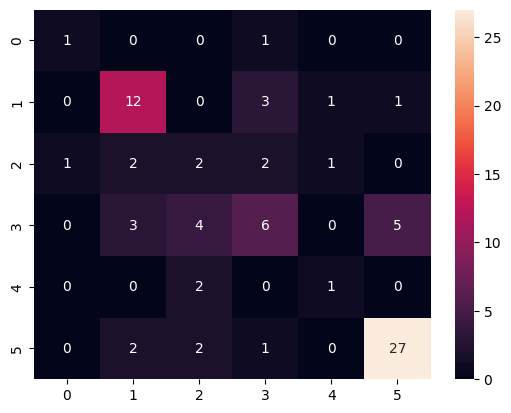

In [281]:
plot_confusion_matrix(model, X_test, y_test.values.argmax(axis=1))

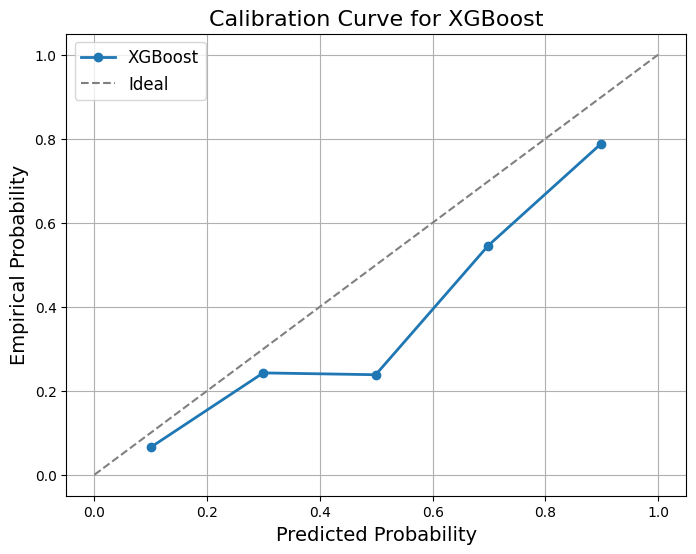

In [282]:
plot_calibration_curve(model.predict_proba(X_test), y_test.values, n_bins=5)